# **Data Preparation and Modelling**

## Objectives

- Developing a solution for Business Requirement No. 2:   
The client seeks to determine the specific variety of rice depicted in the uploaded images.  

This notebook focuses on preparing data for model creation and the model-building process itself:  
- Image Augmentation, enhancing the dataset by generating varied images, increasing the robustness of the model.  
- Iteratively training the model with augmented data to learn and improve its performance.  
- Selecting the Best Model, evaluating different iterations of the trained model to identify the most effective one based on performance metrics.  

## Inputs

- Images are taken from the test, train, validation folders and their subfolders.  

         .
         ├── inputs   
         │   └──datasets_devided
         │      └──rice  
         │           ├── test  
         │           │   ├── Arborio  
         │           │   ├── Basmati  
         │           │   ├── Ipsala  
         │           │   ├── Jasmine 
         │           │   └── Karacadag
         │           ├── train
         │           │   ├── Arborio  
         │           │   ├── Basmati  
         │           │   ├── Ipsala  
         │           │   ├── Jasmine  
         │           │   └── Karacadag
         │           └── validation
         │               ├── Arborio  
         │               ├── Basmati  
         │               ├── Ipsala  
         │               ├── Jasmine  
         │               └── Karacadag  
         └── ...

## Outputs  
- Montage augmented images for each set.  
- Class indices to change prediction inference in labels.  
- Creation of a Machine learning model and display of its summary.  
- Learning curve plot for model performance.  
- Saved best model.

---

# Change working directory

We store our Jupyter notebooks in a subfolder of the project. Therefore, when we run the notebooks in the editor, we need to change the working directory. This is necessary to ensure proper access to data files and other project resources that might be located outside the notebook's subfolder.

We need to change the working directory from its current folder to its parent folder

- To access the current working directory, we use the os.getcwd() command. 

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Rice-Detector/jupyter_notebooks'

Then, we change the working directory from its current folder to its parent folder to facilitate the correct file path references within our notebooks.

- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Rice-Detector'

---

# Image data augmentation

### Augmentation parameters

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt

# Augmentation parameters
augmented_image_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)



2023-12-31 21:03:24.494700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data augmentation can be applied to all machine learning datasets, including validation and test sets, especially in cases of insufficient data volume. However, as a rule, data augmentation is applied only to the training set, not to the validation or test set. This is because data augmentation can lead to model overfitting if it is applied to the validation or test set. In our case, there is a sufficient volume of data. Therefore, we will apply augmentation only to the training set.

### Augment training image set

In [5]:
# Batch size
batch_size = 16

# Path to the training dataset
train_path = 'inputs/datasets_devided/train'

# Specifying image size
image_shape = (224, 224, 3)  

# Augmenting the training dataset
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],  # Only the width and height are needed here
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Displaying the classes
print(train_set.class_indices)


Found 52500 images belonging to 5 classes.
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


### Plot augmented training image set

(16, 224, 224, 3)


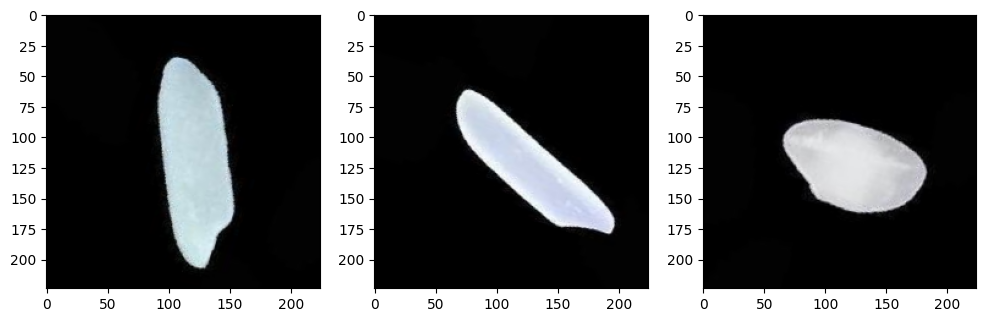

(16, 224, 224, 3)


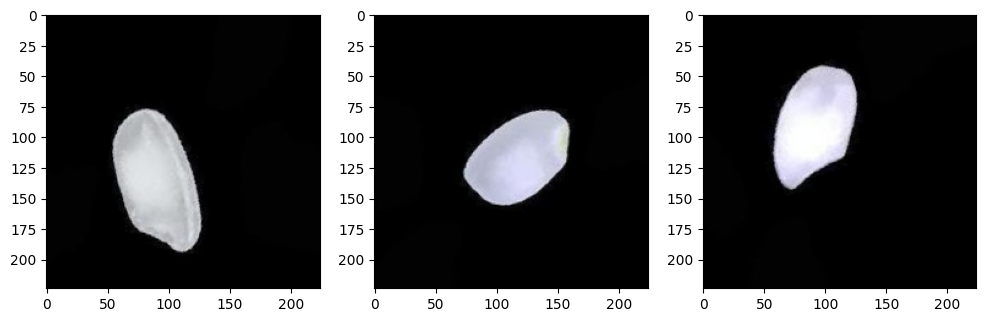

(16, 224, 224, 3)


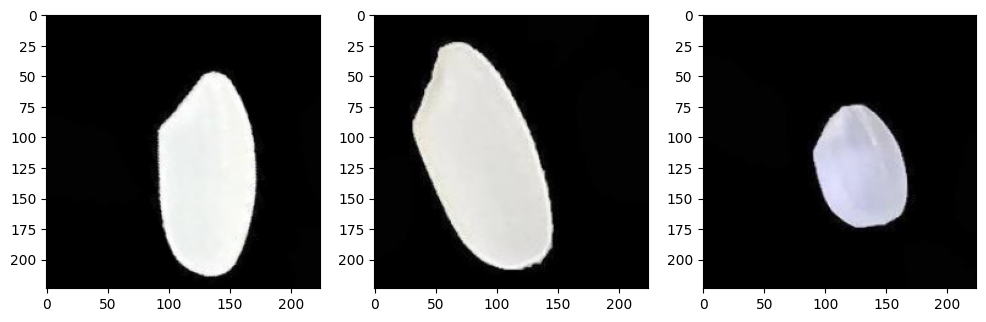

In [6]:
# Displaying augmented images
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(12, 4))
    img, label = train_set.next()
    print(img.shape)  
    for i in range(3):  # Displaying 3 images from the batch
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[i])
    plt.show()

### Save class_indices

In [7]:
import joblib

# Path to directory for saving files
file_path = 'outputs/v1'

# Save class indices from the training set
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

# Print message confirming successful saving
print(f"Class indices saved to {file_path}/class_indices.pkl")

Class indices saved to outputs/v1/class_indices.pkl


---

# Model Creation

### Model

In this TensorFlow model:  

The model utilizes three convolutional layers (Conv2D), each followed by a MaxPooling2D layer. These layers are responsible for extracting and downsampling features from the input images, capturing the essential elements in the images.  

After the convolutional and pooling layers, the output is flattened into a one-dimensional vector. This is then passed through a fully connected Dense layer with 64 neurons, which interprets the features extracted by the convolutional layers.  

To mitigate the risk of overfitting, a Dropout layer with a rate of 0.3 is incorporated. This layer randomly deactivates 30% of the neurons during training, ensuring the model does not become overly dependent on specific features of the training data.  

The final Dense layer comprises 5 neurons, corresponding to the five types of rice varieties. It uses a softmax activation function for multi-class classification, determining the probability of each class.  In multi-class classification, as is the case with the five classes of rice varieties, softmax is the standard choice because it transforms the output values of the model into probabilities that sum up to 1. This allows the model to predict which class each sample most likely belongs to.

In contrast, the sigmoid function is used in binary classification tasks, where it's necessary to predict the probability of belonging to one of two classes. With sigmoid, each output of the model is interpreted independently, making it unsuitable for multi-class classification with exclusive classes.
  
The model is compiled using the Adam optimizer and the categorical_crossentropy loss function, which are common choices for multi-class classification tasks.  

Callbacks:  
 EarlyStopping monitors the val_accuracy metric and stops training if there's no improvement for 3 consecutive epochs, ensuring efficient training.
 Saves the model after every epoch into files named 'model_epoch_{epoch:02d}.keras', facilitating the evaluation and comparison of models at different training stages. This method is crucial to allow manual selection of the best model based on detailed performance metrics.    

The model is trained step-by-step, one epoch at a time. This approach allows for saving the training history after each epoch. The saved history files named 'history_epoch_{epoch:02d}.csv' provide detailed insights into the model's performance across epochs, enabling a more thorough analysis to determine the most effective model.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_tf_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening the layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer (5 classes for 5 types of rice)
    model.add(Dense(5, activation='softmax')) 

    # Compiling the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
epoch_checkpoint = ModelCheckpoint(filepath='outputs/v1/model_epoch_{epoch:02d}.keras', 
                                   save_best_only=False)

# Create and summarize the model
model = create_tf_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 


 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 43264)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2768960   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2797925 (10.67 MB)
Trainable params: 2797925 (10.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fit model for training

In [10]:
from tensorflow.keras.models import load_model
import pandas as pd


# Creating the model
model = create_tf_model()

# Paths to training and validation datasets
train_path = 'inputs/datasets_devided/train'
validation_path = 'inputs/datasets_devided/validation'

# Using the same ImageDataGenerator for training data
train_datagen = augmented_image_data
# No augmentation is required for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators for training and validation
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Training the model

# Preparing for step-by-step training of the model
epochs = 32
for epoch in range(epochs):
    # Train the model for one epoch
    history = model.fit(
        train_set,
        validation_data=validation_set,
        epochs=epoch + 1,  # Specify the final epoch for the current iteration
        initial_epoch=epoch,  # Specify the starting epoch for the current iteration
        callbacks=[early_stop, epoch_checkpoint],
        verbose=1
    )

    # Save the training history to a file
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'outputs/v1/history_epoch_{epoch+1:02d}.csv', index=False)

    # Check for early stopping condition
    if early_stop.stopped_epoch > 0:
        print("Early stopping triggered at epoch", early_stop.stopped_epoch)
        break

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
3282/3282 [==============================] - 1333s 406ms/step - loss: 0.3957 - accuracy: 0.8399 - val_loss: 0.1990 - val_accuracy: 0.9249
Epoch 2/2
3282/3282 [==============================] - 1322s 403ms/step - loss: 0.1441 - accuracy: 0.9513 - val_loss: 0.0338 - val_accuracy: 0.9884
Epoch 3/3
3282/3282 [==============================] - 1308s 399ms/step - loss: 0.1013 - accuracy: 0.9673 - val_loss: 0.0213 - val_accuracy: 0.9922
Epoch 4/4
3282/3282 [==============================] - 1306s 398ms/step - loss: 0.0896 - accuracy: 0.9714 - val_loss: 0.0436 - val_accuracy: 0.9842
Epoch 5/5
3282/3282 [==============================] - 1321s 402ms/step - loss: 0.0730 - accuracy: 0.9768 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 6/6
3282/3282 [==============================] - 1312s 400ms/step - loss: 0.0705 - accuracy: 0.9779 - val_loss: 0.0968 - val_accuracy: 0.9714
Epoch 7/7
3282/3282 [===============

KeyboardInterrupt: 

The model training was manually stopped before the early stopping condition was reached because the developer observed that the model was beginning to overfit.  

From the presented results, the following epochs stand out:  

Epoch 3: val_accuracy = 0.9922, val_loss = 0.0213
Epoch 5: val_accuracy = 0.9924, val_loss = 0.0233
Both of these epochs show high accuracy on the validation data set (>99%). However, the losses in epoch 3 are slightly lower than in epoch 5. This makes epoch 3 a better candidate in terms of the balance between accuracy and losses.

---

## Model Performance

### Model Learning Performance Up to Onset of Overfitting

The code is designed to evaluate model performance across different epochs. It first checks if a specific output directory exists and creates one if it does not. Then, it loads the training history from the first six epochs into a unified dataset. With this dataset, it creates two line plots: one for the loss and another for the accuracy over the epochs. These plots help visualize how the model's performance changes over time, providing insights into when the model might be overfitting. The loss plot displays both the training and validation loss, while the accuracy plot shows the training and validation accuracy. Both plots are saved as image files in a specified directory.

<Figure size 500x300 with 0 Axes>

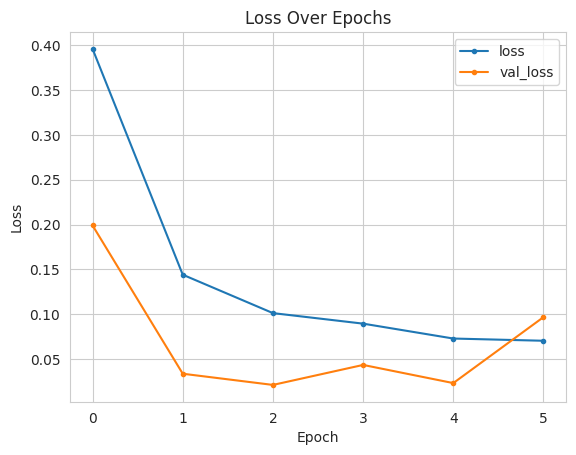

<Figure size 500x300 with 0 Axes>

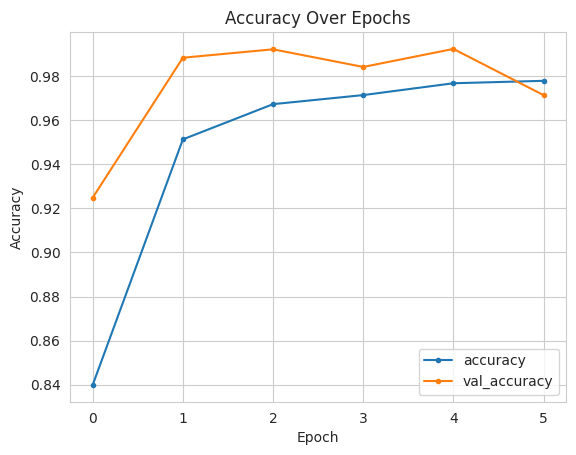

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check if directory exists, if not, create it
output_dir = 'outputs/performance'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load data for epochs 1-6
all_epochs_data = pd.concat([load_epoch_data(e, 'outputs/v1') for e in range(1, 7)], ignore_index=True)

# Plot for losses
plt.figure(figsize=(5, 3))  # Set the size of the figure
sns.set_style("whitegrid")  # Set the style of the plot to 'whitegrid'
all_epochs_data[['loss', 'val_loss']].plot(style='.-')  # Plot training and validation losses
plt.title("Loss Over Epochs")  # Title of the plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.savefig(f'{output_dir}/loss_over_epochs.png', bbox_inches='tight', dpi=150)  # Save the plot as an image file

# Plot for accuracy
plt.figure(figsize=(5, 3))  # Set the size of the figure
all_epochs_data[['accuracy', 'val_accuracy']].plot(style='.-')  # Plot training and validation accuracy
plt.title("Accuracy Over Epochs")  # Title of the plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.savefig(f'{output_dir}/accuracy_over_epochs.png', bbox_inches='tight', dpi=150)  # Save the plot as an image file
plt.show()  # Display the plot

### Comprehensive Model Learning Dynamics

This code block is designed to provide a comprehensive visualization of the model's learning dynamics over multiple training epochs. By creating a combined plot that displays both loss and accuracy on primary and secondary axes, we can observe the correlation between how the model minimizes loss and maximizes accuracy simultaneously. This dual-axis plot gives a clearer picture of the model's performance and aids in identifying the point at which the model achieves optimal balance, potentially signaling when to cease training to prevent overfitting. The plot is generated using Plotly, which allows for interactive exploration of the data points. The resulting graph is then saved to a designated output directory for further analysis and reference. This step consolidates and compares the learning trends within a single cohesive visual framework, making it easier to spot patterns and decide on the best model epoch to use for predictions.

In [15]:
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Check if directory exists, if not, create it
output_dir = 'outputs/performance'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Creating the plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding loss traces
fig.add_trace(go.Scatter(y=all_epochs_data['val_loss'], name="Validation Loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=all_epochs_data['loss'], name="Training Loss"), secondary_y=False)

# Adding accuracy traces
fig.add_trace(go.Scatter(y=all_epochs_data['val_accuracy'], name="Validation Accuracy"), secondary_y=True)
fig.add_trace(go.Scatter(y=all_epochs_data['accuracy'], name="Training Accuracy"), secondary_y=True)

# Setting title and axes
fig.update_layout(title_text="Loss/Accuracy Over Epochs")
fig.update_xaxes(title_text="Epoch")  # X-axis label
fig.update_yaxes(title_text="<b>Primary</b> Loss", secondary_y=False)  # Y-axis label for loss
fig.update_yaxes(title_text="<b>Secondary</b> Accuracy", secondary_y=True)  # Y-axis label for accuracy

# Displaying and saving the plot
fig.show()
fig.write_image(f'{output_dir}/combined_loss_accuracy_plot.png')  # Save the plot as an image file

The previous graphs were line plots created using Matplotlib and Seaborn, which are different from the interactive Plotly graph created later. While the previous graphs serve a similar purpose in displaying the learning trends over epochs, there are several reasons why we choose to create different types of graphs:

Having multiple visualizations allows you to compare and confirm findings. If both visualizations show the same trends, you can be more confident in your conclusions.

Different stakeholders may prefer different types of visualizations. Interactive graphs created with Plotly can be more engaging and informative for presentations, whereas static graphs might be required for formal reports or publications.

Interactive graphs like those made with Plotly offer additional features such as zooming and hovering to display precise data points, which can be beneficial for a detailed analysis.

Building different types of graphs can be a learning experience in itself, allowing you to explore the capabilities of various libraries and understand which type of graph is more effective under different circumstances.

Having multiple graphs can serve as a backup. If one graph fails to generate properly or does not convey the information effectively, you have alternatives.



**Considering the data presented in the epoch outputs:**  

Epoch 2 shows high accuracy on the validation dataset (0.9884) and low loss (0.0338).
Epoch 3 demonstrates even higher validation accuracy (0.9922) and lower loss (0.0213).
Epoch 5 also shows high accuracy (0.9924), but the loss is slightly higher (0.0233) compared to Epoch 3.
From this, we can conclude that the model achieved the best balance between accuracy and losses in Epoch 3. Although the accuracy in Epoch 5 is slightly higher, the losses in Epoch 3 are lower, making it the preferable choice.   

Here are several reasons why **epoch 3 appears to be the best**:  

Minimum Validation Loss:   
The loss graph shows that at the third epoch, the validation loss reaches its lowest value, indicating good model performance on data it hasn't seen before.  

High Validation Accuracy:  
Accuracy on the validation set also peaks at the third epoch, suggesting that the model correctly classifies a large portion of the validation data.  

Stability of Metrics:  
While the validation accuracy remains relatively stable even after the third epoch, the increase in loss may indicate the beginning of overfitting. Choosing the third epoch helps to avoid this risk.  

Training/Validation Ratio:  
The ratio of metrics on the training and validation data sets remains balanced at the third epoch, which is a good sign of the model's generalization ability.  

### Save the final model

In [16]:
import shutil

# Path to the source model file (chosen best model)
source_model_path = 'outputs/v1/model_epoch_03.keras'

# Path where the selected model will be saved
destination_model_path = 'outputs/final_model/final_rice_model.keras'

# Create the directory if it does not exist
os.makedirs(os.path.dirname(destination_model_path), exist_ok=True)

# Copying the model file
shutil.copyfile(source_model_path, destination_model_path)

print(f"Model copied to {destination_model_path}")

Model copied to outputs/final_model/final_rice_model.keras
